# Example 3 - Missing not at Random

In [1]:
import numpy as np
import time
import sys, os
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import miceforest as mf

d = 2
alpha = 1
betas = np.ones(d)
gammas = np.ones(d)

%run 'all_imputations.ipynb'
%run 'all_classifiers.ipynb'

In [2]:
''' Set Constants '''
iterations = 100 # number of iterations for estimating the empirical test error
N_test = 1000

all_accuracies_cc_kNN = np.zeros((2,iterations))
all_accuracies_mi_kNN = np.zeros((2,iterations))
all_accuracies_ci_kNN = np.zeros((2,iterations))
all_accuracies_mf_kNN = np.zeros((2,iterations))
all_accuracies_oracle_HAM = np.zeros((2,iterations))
all_accuracies_HAM = np.zeros((2,iterations))
all_accuracies_cvHAM = np.zeros((2,iterations))
all_accuracies_full_kNN = np.zeros((2,iterations))
all_accuracies_mice_kNN = np.zeros((2,iterations))


Omega_star = []
Omega_star.append(np.array([1,0],dtype="int"))
Omega_star.append(np.array([0,1],dtype="int"))

def eta(x):
    return 1/4+x[0]/2+np.cos(4*np.pi*x[1])/4


Bayes_risk = 0
for _ in range(1000000):
    eta_point = eta(np.random.uniform(size=d))
    Bayes_risk += min(eta_point,1-eta_point)
Bayes_risk = Bayes_risk/1000000
print('Bayes risk = ', np.round(Bayes_risk,4))

Bayes risk =  0.3124


Runtime Complete Case kNN (in s):  1.3
    Accuracy:  0.6
Runtime Mean Imputation and kNN (in s):  1.607
    Accuracy:  0.614
Runtime Constant Imputation and kNN (in s):  1.601
    Accuracy:  0.589
Runtime MissForest and kNN (in s):  2.053
    Accuracy:  0.627
Runtime Oracle HAM (in s):  4.608
    Accuracy:  0.673
Runtime HAM (in s):  5.316
    Accuracy:  0.663
alpha =  0
betas =  [1 1]
gammas =  [0.5 0.5]
Runtime cvHAM (in s):  69.863
    Accuracy:  0.629
Runtime Full kNN, everything observed (in s):  1.644
    Accuracy:  0.611
Runtime mice and kNN (in s):  18.881
    Accuracy:  0.608

Estimated runtime (in min):  178.119


Test Accuracy Complete Case kNN:  0.6022
Test Accuracy c=0 Imputation then kNN:  0.5949
Test Accuracy Mean Imputation then kNN  :  0.596
Test Accuracy Random Forest Imputation then kNN:  0.5927
Test Accuracy MissForest then kNN:  0.5863
Test Accuracy HAM:  0.6341
Test Accuracy cvHAM:  0.6237
Test Accuracy Oracle HAM:  0.6561
Test Accuracy Full kNN (no missingness):

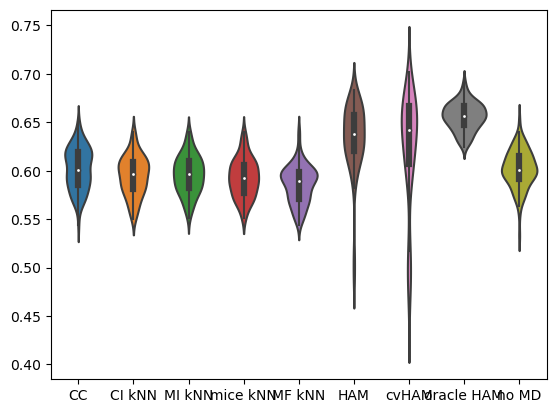

Runtime Complete Case kNN (in s):  2.643
    Accuracy:  0.631
Runtime Mean Imputation and kNN (in s):  3.338
    Accuracy:  0.621
Runtime Constant Imputation and kNN (in s):  3.317
    Accuracy:  0.625
Runtime MissForest and kNN (in s):  3.662
    Accuracy:  0.59
Runtime Oracle HAM (in s):  9.197
    Accuracy:  0.672
Runtime HAM (in s):  12.033
    Accuracy:  0.672
alpha =  0
betas =  [1 1]
gammas =  [0.5 0.5]
Runtime cvHAM (in s):  252.942
    Accuracy:  0.697
Runtime Full kNN, everything observed (in s):  3.37
    Accuracy:  0.618
Runtime mice and kNN (in s):  24.572
    Accuracy:  0.601

Estimated runtime (in min):  525.123


Test Accuracy Complete Case kNN:  0.6014
Test Accuracy c=0 Imputation then kNN:  0.5959
Test Accuracy Mean Imputation then kNN  :  0.5968
Test Accuracy Random Forest Imputation then kNN:  0.5911
Test Accuracy MissForest then kNN:  0.5814
Test Accuracy HAM:  0.6534
Test Accuracy cvHAM:  0.6507
Test Accuracy Oracle HAM:  0.6642
Test Accuracy Full kNN (no missingn

In [3]:
'''
EXAMPLE 3 - MNAR
'''


N_train = 500 


''' 
Create 1 training and test point set, show runtime and calculate expected run time for simulation 
'''
# Generate Training Data 
X_train = np.random.uniform(size=(N_train,d))
Y_train = np.zeros(N_train)
O_train = np.zeros((N_train,d))
for i in range(N_train):
    Y_train[i] = np.random.random() < eta(X_train[i,:]) 
    if X_train[i,1]<=1/2:
        if np.random.random()<1/2:
            O_train[i] = np.array([1,1],dtype="int")
        elif np.random.random()<1/3:
            O_train[i] = np.array([1,0],dtype="int")
        elif np.random.random()<1/2:
            O_train[i] = np.array([0,1],dtype="int")
        else:
            O_train[i] = np.array([0,0],dtype="int")    
    else:
        if np.random.random()<1/4:
            O_train[i] = np.array([1,1],dtype="int")
        elif np.random.random()<1/3:
            O_train[i] = np.array([1,0],dtype="int")
        elif np.random.random()<1/2:
            O_train[i] = np.array([0,1],dtype="int")
        else:
            O_train[i] = np.array([0,0],dtype="int")  

# Generate Test Points
x_test = np.random.uniform(size=(N_test,d))
y_test = np.zeros(N_test)
for i in range(N_test):
    y_test[i] = np.random.random() < eta(x_test[i,:])  
    
%run 'run_different_classifiers_on_data_and_print_times.ipynb'



''' 
Create training and test point sets, estimate empirical test error
'''
accuracy_cc_kNN = np.zeros(iterations)
accuracy_mi_kNN = np.zeros(iterations)
accuracy_ci_kNN = np.zeros(iterations)
accuracy_mf_kNN = np.zeros(iterations)
accuracy_oracle_HAM = np.zeros(iterations)
accuracy_HAM = np.zeros(iterations)
accuracy_cvHAM = np.zeros(iterations)
accuracy_full_kNN = np.zeros(iterations)
accuracy_mice_kNN = np.zeros(iterations)

for it in range(iterations):
    
    # Generate Training Data 
    X_train = np.random.uniform(size=(N_train,d))
    Y_train = np.zeros(N_train)
    O_train = np.zeros((N_train,d))
    for i in range(N_train):
        Y_train[i] = np.random.random() < eta(X_train[i,:])  
        if X_train[i,1]<=1/2:
            if np.random.random()<1/2:
                O_train[i] = np.array([1,1],dtype="int")
            elif np.random.random()<1/3:
                O_train[i] = np.array([1,0],dtype="int")
            elif np.random.random()<1/2:
                O_train[i] = np.array([0,1],dtype="int")
            else:
                O_train[i] = np.array([0,0],dtype="int")    
        else:
            if np.random.random()<1/4:
                O_train[i] = np.array([1,1],dtype="int")
            elif np.random.random()<1/3:
                O_train[i] = np.array([1,0],dtype="int")
            elif np.random.random()<1/2:
                O_train[i] = np.array([0,1],dtype="int")
            else:
                O_train[i] = np.array([0,0],dtype="int")  

    # Generate Test Points
    x_test = np.random.uniform(size=(N_test,d))
    y_test = np.zeros(N_test)
    for i in range(N_test):
        y_test[i] = np.random.random() < eta(x_test[i,:])  
     
    %run 'run_different_classifiers_on_data.ipynb'


all_accuracies_cc_kNN[0,:] = accuracy_cc_kNN[0:iterations]
all_accuracies_mi_kNN[0,:] = accuracy_mi_kNN[0:iterations]
all_accuracies_ci_kNN[0,:] = accuracy_ci_kNN[0:iterations]
all_accuracies_mf_kNN[0,:] = accuracy_mf_kNN[0:iterations]
all_accuracies_oracle_HAM[0,:] = accuracy_oracle_HAM[0:iterations]
all_accuracies_HAM[0,:] = accuracy_HAM[0:iterations]
all_accuracies_cvHAM[0,:] = accuracy_cvHAM[0:iterations]
all_accuracies_full_kNN[0,:] = accuracy_full_kNN[0:iterations]
all_accuracies_mice_kNN[0,:] = accuracy_mice_kNN[0:iterations]
    
print('\n\nTest Accuracy Complete Case kNN: ',np.round(np.sum(accuracy_cc_kNN)/iterations,4))
print('Test Accuracy c=0 Imputation then kNN: ',np.round(np.sum(accuracy_ci_kNN)/iterations,4))
print('Test Accuracy Mean Imputation then kNN  : ',np.round(np.sum(accuracy_mi_kNN)/iterations,4))
print('Test Accuracy Random Forest Imputation then kNN: ',np.round(np.sum(accuracy_mice_kNN)/iterations,4))
print('Test Accuracy MissForest then kNN: ',np.round(np.sum(accuracy_mf_kNN)/iterations,4))
print('Test Accuracy HAM: ',np.round(np.sum(accuracy_HAM)/iterations,4))
print('Test Accuracy cvHAM: ',np.round(np.sum(accuracy_cvHAM)/iterations,4))
print('Test Accuracy Oracle HAM: ',np.round(np.sum(accuracy_oracle_HAM)/iterations,4))
print('Test Accuracy Full kNN (no missingness): ',np.round(np.sum(accuracy_full_kNN)/iterations,4))

summary_accuracies = [accuracy_cc_kNN,accuracy_ci_kNN,accuracy_mi_kNN,accuracy_mice_kNN,accuracy_mf_kNN,accuracy_HAM,accuracy_cvHAM,accuracy_oracle_HAM,accuracy_full_kNN]
summary_plot = sns.violinplot(summary_accuracies)

summary_plot.set_xticklabels(['CC','CI kNN','MI kNN','mice kNN','MF kNN','HAM','cvHAM','oracle HAM','no MD'])

plt.show(summary_plot)

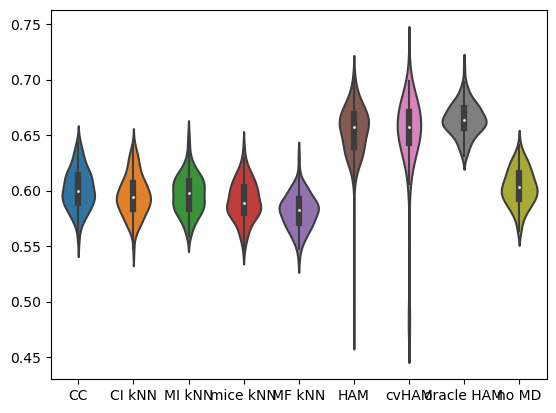

In [4]:
'''
EXAMPLE 3  
'''


N_train = 1000


''' 
Create 1 training and test point set, show runtime and calculate expected run time for simulation 
'''
# Generate Training Data 
X_train = np.random.uniform(size=(N_train,d))
Y_train = np.zeros(N_train)
O_train = np.zeros((N_train,d))
for i in range(N_train):
    Y_train[i] = np.random.random() < eta(X_train[i,:]) 
    if X_train[i,1]<=1/2:
        if np.random.random()<1/2:
            O_train[i] = np.array([1,1],dtype="int")
        elif np.random.random()<1/3:
            O_train[i] = np.array([1,0],dtype="int")
        elif np.random.random()<1/2:
            O_train[i] = np.array([0,1],dtype="int")
        else:
            O_train[i] = np.array([0,0],dtype="int")    
    else:
        if np.random.random()<1/4:
            O_train[i] = np.array([1,1],dtype="int")
        elif np.random.random()<1/3:
            O_train[i] = np.array([1,0],dtype="int")
        elif np.random.random()<1/2:
            O_train[i] = np.array([0,1],dtype="int")
        else:
            O_train[i] = np.array([0,0],dtype="int")  

# Generate Test Points
x_test = np.random.uniform(size=(N_test,d))
y_test = np.zeros(N_test)
for i in range(N_test):
    y_test[i] = np.random.random() < eta(x_test[i,:]) 

%run 'run_different_classifiers_on_data_and_print_times.ipynb'



''' 
Create training and test point sets, estimate empirical test error
'''
accuracy_cc_kNN = np.zeros(iterations)
accuracy_mi_kNN = np.zeros(iterations)
accuracy_ci_kNN = np.zeros(iterations)
accuracy_mf_kNN = np.zeros(iterations)
accuracy_oracle_HAM = np.zeros(iterations)
accuracy_HAM = np.zeros(iterations)
accuracy_cvHAM = np.zeros(iterations)
accuracy_full_kNN = np.zeros(iterations)
accuracy_mice_kNN = np.zeros(iterations)

for it in range(iterations):
    
    # Generate Training Data 
    X_train = np.random.uniform(size=(N_train,d))
    Y_train = np.zeros(N_train)
    O_train = np.zeros((N_train,d))
    for i in range(N_train):
        Y_train[i] = np.random.random() < eta(X_train[i,:])  
        if X_train[i,1]<=1/2:
            if np.random.random()<1/2:
                O_train[i] = np.array([1,1],dtype="int")
            elif np.random.random()<1/3:
                O_train[i] = np.array([1,0],dtype="int")
            elif np.random.random()<1/2:
                O_train[i] = np.array([0,1],dtype="int")
            else:
                O_train[i] = np.array([0,0],dtype="int")    
        else:
            if np.random.random()<1/4:
                O_train[i] = np.array([1,1],dtype="int")
            elif np.random.random()<1/3:
                O_train[i] = np.array([1,0],dtype="int")
            elif np.random.random()<1/2:
                O_train[i] = np.array([0,1],dtype="int")
            else:
                O_train[i] = np.array([0,0],dtype="int")  

    # Generate Test Points
    x_test = np.random.uniform(size=(N_test,d))
    y_test = np.zeros(N_test)
    for i in range(N_test):
        y_test[i] = np.random.random() < eta(x_test[i,:])  
        
    %run 'run_different_classifiers_on_data.ipynb'


all_accuracies_cc_kNN[1,:] = accuracy_cc_kNN[0:iterations]
all_accuracies_mi_kNN[1,:] = accuracy_mi_kNN[0:iterations]
all_accuracies_ci_kNN[1,:] = accuracy_ci_kNN[0:iterations]
all_accuracies_mf_kNN[1,:] = accuracy_mf_kNN[0:iterations]
all_accuracies_oracle_HAM[1,:] = accuracy_oracle_HAM[0:iterations]
all_accuracies_HAM[1,:] = accuracy_HAM[0:iterations]
all_accuracies_cvHAM[1,:] = accuracy_cvHAM[0:iterations]
all_accuracies_full_kNN[1,:] = accuracy_full_kNN[0:iterations]
all_accuracies_mice_kNN[1,:] = accuracy_mice_kNN[0:iterations]
    
print('\n\nTest Accuracy Complete Case kNN: ',np.round(np.sum(accuracy_cc_kNN)/iterations,4))
print('Test Accuracy c=0 Imputation then kNN: ',np.round(np.sum(accuracy_ci_kNN)/iterations,4))
print('Test Accuracy Mean Imputation then kNN  : ',np.round(np.sum(accuracy_mi_kNN)/iterations,4))
print('Test Accuracy Random Forest Imputation then kNN: ',np.round(np.sum(accuracy_mice_kNN)/iterations,4))
print('Test Accuracy MissForest then kNN: ',np.round(np.sum(accuracy_mf_kNN)/iterations,4))
print('Test Accuracy HAM: ',np.round(np.sum(accuracy_HAM)/iterations,4))
print('Test Accuracy cvHAM: ',np.round(np.sum(accuracy_cvHAM)/iterations,4))
print('Test Accuracy Oracle HAM: ',np.round(np.sum(accuracy_oracle_HAM)/iterations,4))
print('Test Accuracy Full kNN (no missingness): ',np.round(np.sum(accuracy_full_kNN)/iterations,4))

summary_accuracies = [accuracy_cc_kNN,accuracy_ci_kNN,accuracy_mi_kNN,accuracy_mice_kNN,accuracy_mf_kNN,accuracy_HAM,accuracy_cvHAM,accuracy_oracle_HAM,accuracy_full_kNN]
summary_plot = sns.violinplot(summary_accuracies)

summary_plot.set_xticklabels(['CC','CI kNN','MI kNN','mice kNN','MF kNN','HAM','cvHAM','oracle HAM','no MD'])

plt.show(summary_plot)

In [5]:
''' Save accuracies for further use '''

np.save('Ex3_all_accuracies_cc_kNN',all_accuracies_cc_kNN)
np.save('Ex3_all_accuracies_mi_kNN',all_accuracies_mi_kNN)
np.save('Ex3_all_accuracies_ci_kNN',all_accuracies_ci_kNN)
np.save('Ex3_all_accuracies_mf_kNN',all_accuracies_mf_kNN)
np.save('Ex3_all_accuracies_oracle_HAM',all_accuracies_oracle_HAM)
np.save('Ex3_all_accuracies_HAM',all_accuracies_HAM)
np.save('Ex3_all_accuracies_cvHAM',all_accuracies_cvHAM)
np.save('Ex3_all_accuracies_full_kNN',all_accuracies_full_kNN)
np.save('Ex3_all_accuracies_mice_kNN',all_accuracies_mice_kNN)
np.save('Ex3_Bayes_risk',Bayes_risk)


np.save('Ex3_MNAR_all_accuracies_cc_kNN',all_accuracies_cc_kNN)
np.save('Ex3_MNAR_all_accuracies_mi_kNN',all_accuracies_mi_kNN)
np.save('Ex3_MNAR_all_accuracies_ci_kNN',all_accuracies_ci_kNN)
np.save('Ex3_MNAR_all_accuracies_mf_kNN',all_accuracies_mf_kNN)
np.save('Ex3_MNAR_all_accuracies_oracle_HAM',all_accuracies_oracle_HAM)
np.save('Ex3_MNAR_all_accuracies_HAM',all_accuracies_HAM)
np.save('Ex3_MNAR_all_accuracies_cvHAM',all_accuracies_cvHAM)
np.save('Ex3_MNAR_all_accuracies_full_kNN',all_accuracies_full_kNN)
np.save('Ex3_MNAR_all_accuracies_mice_kNN',all_accuracies_mice_kNN)
np.save('Ex3_MNAR_Bayes_risk',Bayes_risk)